In [1]:
import pandas as pd
import datetime
from sklearn.neural_network import MLPClassifier
import random
import torch
from net import gtnet
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-v8kt83ss because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
list_users_above_criteria = [
        1032,
        581,
        407,
        290,
        1436,
        1000,
        95,
        1386,
        1431,
        992,
        1717,
        1441,
        122,
        977,
        293,
        1700,
        1744,
        622,

        192,
        1373,
        84,
        1393,
        1432,
        1378,
        225,
        1753,
        2084,
        969,
        280,
        99,
        53,
        983,
        2068,
        193,
        2056,
        2016,
        2109, 
        1995,
        1706,
        2015,
        186,
        137,
        1658,
        2083,
        1383,
        429,
        279]
print(len(list_users_above_criteria))

47


In [3]:
seq_len = 14
selected_user = 1032
# 1431 and 95 have bug, excluded for now
# user_lst = [290, 407, 581, 1032, 1436, 1000, 1386]
user_lst = list_users_above_criteria
def match_dataset_date(selected_user, seq_len):
    y_df = pd.read_csv(f'/mnt/results/user_{selected_user}_puqe.csv')
    x_df = pd.read_csv(f'/mnt/results/user_{selected_user}_activity_bodyport_hyperimpute_with_date.csv')
    y_df['date'] = pd.to_datetime(y_df['date'])
    x_df['date'] = pd.to_datetime(x_df['date'])
    dataset = []
    for i in range(len(y_df)):
        row = y_df.iloc[i]
        day_before = row['date'] - datetime.timedelta(days=seq_len)
        x = (x_df[(x_df['date'] > day_before) & (x_df['date'] <= row['date'])])
        dataset.append((x.drop('date', axis=1).to_numpy(), row['answer_text'], selected_user))
    return dataset
# gnn_dataset_1032 = match_dataset_date(selected_user, seq_len)
# gnn_dataset_1032 = list(filter(lambda x: len(x[0])>=seq_len, gnn_dataset))
# baseline_dataset_1032 = list(map(lambda x: (x[0][-7:], x[1]), gnn_dataset))
baseline_ds_lst = []
gnn_ds_lst = []
for u in user_lst:
    temp_dataset = match_dataset_date(u, seq_len)
    temp_dataset = list(filter(lambda x: len(x[0])>=seq_len, temp_dataset))
    gnn_ds_lst.append(temp_dataset)
    baseline_dataset = list(map(lambda x: (x[0][-7:], x[1], x[2]), temp_dataset))
    baseline_ds_lst.append(baseline_dataset)
print(len(baseline_ds_lst))
print(len(gnn_ds_lst))

47
47


In [4]:
# dynamic time warping
from tslearn.metrics import dtw
def get_similarities(target_user, user_lst):
    result = []
    target_user_df = pd.read_csv(f'/mnt/results/user_{target_user}_activity_bodyport_hyperimpute_with_date.csv').drop('date', axis=1)
    for user in user_lst:
        if user == target_user:
            continue
        else:
            curr_user_df = pd.read_csv(f'/mnt/results/user_{user}_activity_bodyport_hyperimpute_with_date.csv').drop('date', axis=1)
            result.append((user, dtw(target_user_df, curr_user_df)))
    return sorted(result, key=lambda x: x[1])
print(get_similarities(186, user_lst))

[(1000, 27587.69482799106), (193, 29987.377755994836), (2015, 30593.875131389977), (622, 31026.78320774454), (2068, 31433.845939681396), (2109, 31585.114034522652), (1431, 33399.73732584675), (1436, 33547.978397639694), (1995, 33661.80988368422), (1383, 34640.67486897988), (290, 37135.59110037308), (2016, 37278.54649741161), (1753, 40076.093345991074), (407, 40683.83265929175), (293, 40788.83175357726), (137, 40882.18448643907), (84, 42221.514482975064), (122, 42665.38262076383), (95, 45914.26719677829), (2083, 50422.74241740617), (1700, 52864.72219731747), (1706, 53173.272911509535), (1386, 55011.47922111432), (2056, 55534.78814022323), (225, 56155.94126348987), (1744, 57085.10181241482), (1717, 63503.13551046357), (2084, 64188.87007037306), (1432, 66283.5064408502), (429, 70716.1262078943), (280, 70958.30672071024), (969, 71233.14945049636), (1032, 71441.8189049842), (99, 71795.42117721344), (1373, 78604.20570314662), (279, 79737.87245892915), (1658, 81261.72699161846), (992, 82743.1

In [5]:
# args = {'data': '/mnt/results/user_456546_activity_bodyport_hyperimpute.csv', 'log_interval': 2000, 'optim': 'adam', 'L1Loss': True, 'normalize': 2, 'device': 'cuda:0', 'gcn_true': True, 'buildA_true': True, 'gcn_depth': 2, 'num_nodes': 19, 'dropout': 0.3, 'subgraph_size': 19, 'node_dim': 40, 'dilation_exponential': 2, 'conv_channels': 16, 'residual_channels': 16, 'skip_channels': 32, 'end_channels': 64, 'in_dim': 1, 'seq_in_len': 14, 'seq_out_len': 1, 'horizon': 7, 'layers': 5, 'batch_size': 32, 'lr': 0.0001, 'weight_decay': 1e-05, 'clip': 5, 'propalpha': 0.05, 'tanhalpha': 3, 'epochs': 50, 'num_split': 1, 'step_size': 100}
device = torch.device('cuda:0')
torch.set_num_threads(3)
gnn_raw_copy = gnn_ds_lst.copy()
gnn_ds_lst = []

# user_data format [(X's, y's), ...]
def get_gnn_output(gnn_user_id, user_data):
    model = torch.load(f'/mnt/results/model/model_{gnn_user_id}.pt')
    model.to(device)
    model.eval()
    result = []
    for j in range(len(user_data)):
        # print(d[0].shape)
        curr = user_data[j]
        X = torch.from_numpy(curr[0]).unsqueeze(0).unsqueeze(0).permute(0,1,3,2)
        # print(X.shape)
        X.to(device)
        X = X.type(torch.cuda.FloatTensor)
        out = model(X)
        out = out.squeeze(0).squeeze(0).squeeze(-1)
        result.append((out.detach().cpu().numpy(), curr[1], curr[2]))
    return result

for i in range(len(user_lst)):
    gnn_ds_lst.append(get_gnn_output(user_lst[i], gnn_raw_copy[i]))


In [6]:
def generate_tsne_2d(gnn_ds_lst):
    all_gnn_data = []
    for user_data in gnn_ds_lst:
        all_gnn_data.extend(user_data)
    gnn_embeddings = list(map(lambda x: np.expand_dims(x[0], axis=0), all_gnn_data))
    print(gnn_embeddings[0].shape)
    class_labels = list(map(lambda x: x[1], all_gnn_data))
    user_labels = list(map(lambda x: x[2], all_gnn_data))
    gnn_embeddings = np.concatenate(gnn_embeddings, axis=0)
    print(gnn_embeddings.shape)
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)
    # tsne_results = tsne.fit_transform(pca_result)
    tsne_results = tsne.fit_transform(gnn_embeddings)

    df_tsne = pd.DataFrame(tsne_results, columns=["X", "Y"])

    df_tsne["user_labels"] = user_labels
    df_tsne["user_labels"] = df_tsne["user_labels"].apply(lambda i: str(i))

    class_map = ['mild', 'medium', 'severe']
    df_tsne["class_labels"] = class_labels
    df_tsne["class_labels"] = df_tsne["class_labels"].apply(lambda i: class_map[i])
    return df_tsne
df_tsne = generate_tsne_2d(gnn_ds_lst)

(1, 19)
(892, 19)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 892 samples in 0.000s...
[t-SNE] Computed neighbors for 892 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 892 / 892
[t-SNE] Mean sigma: 17.548349
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.744083
[t-SNE] KL divergence after 300 iterations: 0.356928


<AxesSubplot:xlabel='X', ylabel='Y'>

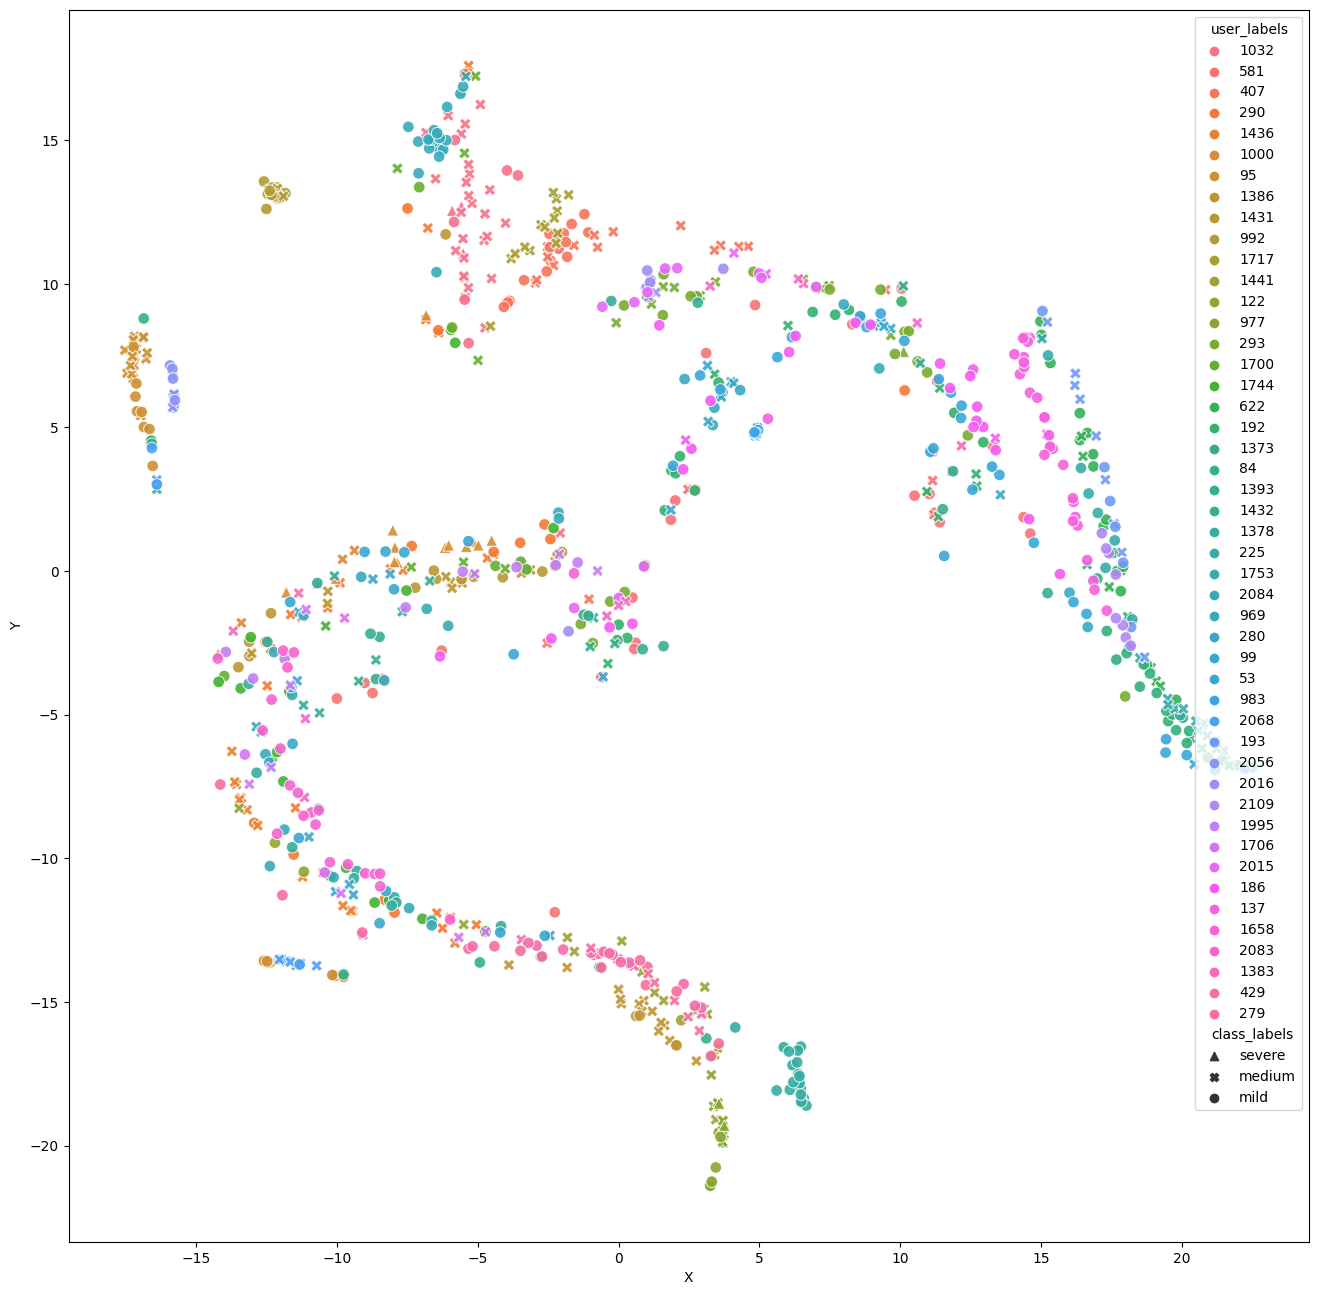

In [7]:
markers_dict = {
    'mild': 'o',
    'medium': 'X',
    'severe': '^'

}
plt.figure(figsize=(16,16))

sns.scatterplot(
    x="X", y="Y",
    hue="user_labels",
    style="class_labels",
    data=df_tsne,
    legend="full", s=70,
    alpha=0.9,
    markers=markers_dict
)

<AxesSubplot:xlabel='X', ylabel='Y'>

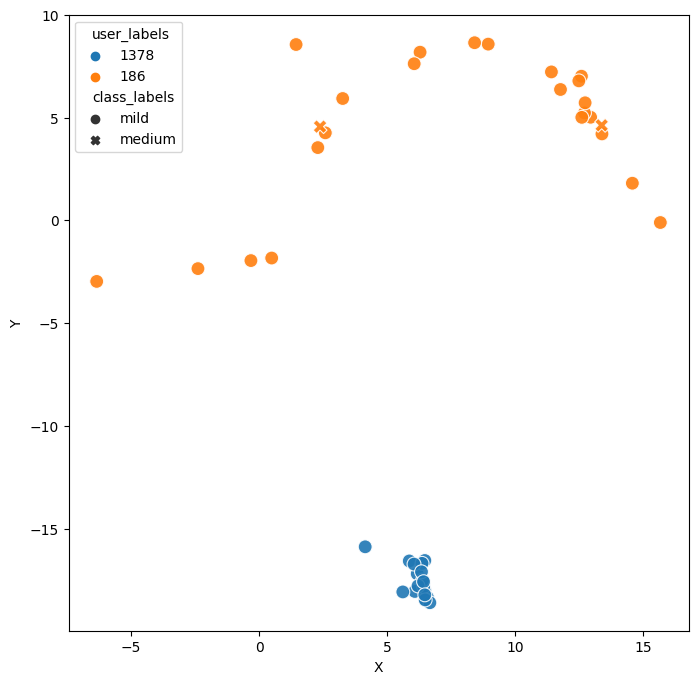

In [25]:
plt.figure(figsize=(8,8))

sns.scatterplot(
    x="X", y="Y",
    hue="user_labels",
    style="class_labels",
    data=df_tsne.loc[(df_tsne['user_labels'] == '1378') | (df_tsne['user_labels'] == '186')],
    legend="full", s=100,
    alpha=0.9,
    markers=markers_dict
)

<AxesSubplot:xlabel='X', ylabel='Y'>

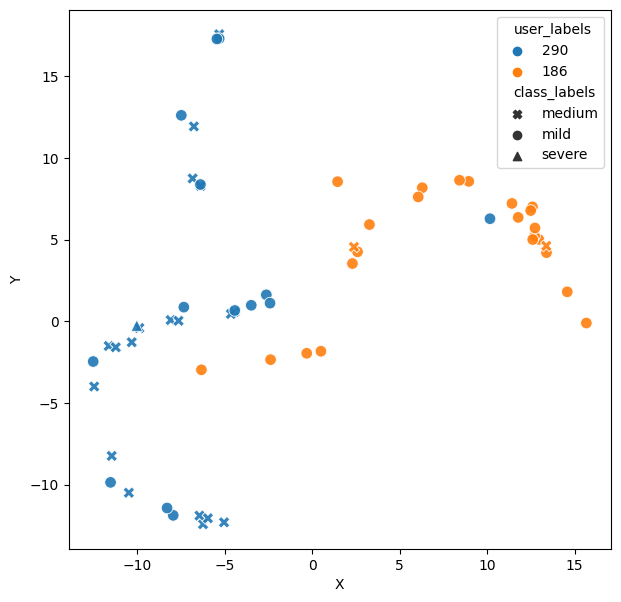

In [24]:
plt.figure(figsize=(7,7))

sns.scatterplot(
    x="X", y="Y",
    hue="user_labels",
    style="class_labels",
    data=df_tsne.loc[(df_tsne['user_labels'] == '290') | (df_tsne['user_labels'] == '186')],
    legend="full", s=70,
    alpha=0.9,
    markers=markers_dict
)

<AxesSubplot:xlabel='X', ylabel='Y'>

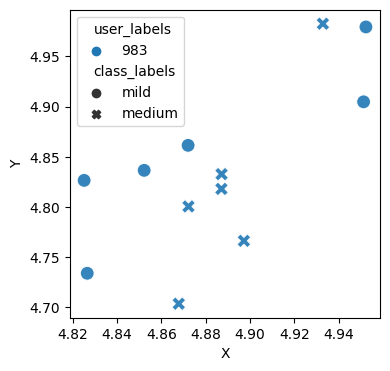

In [10]:
plt.figure(figsize=(4,4))

sns.scatterplot(
    x="X", y="Y",
    hue="user_labels",
    style="class_labels",
    data=df_tsne.loc[(df_tsne['user_labels'] == '983')],
    legend="full", s=100,
    alpha=0.9,
    markers=markers_dict
)

<AxesSubplot:xlabel='X', ylabel='Y'>

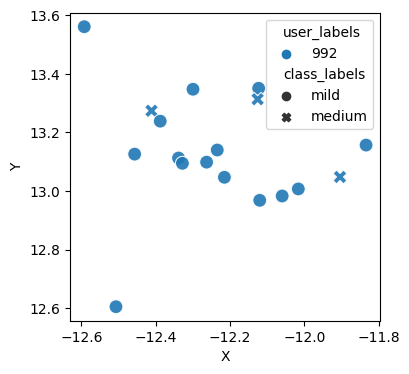

In [11]:
plt.figure(figsize=(4,4))

sns.scatterplot(
    x="X", y="Y",
    hue="user_labels",
    style="class_labels",
    data=df_tsne.loc[(df_tsne['user_labels'] == '992')],
    legend="full", s=100,
    alpha=0.9,
    markers=markers_dict
)

In [26]:
# now we use 992's model to generate 983's embedding
left_user = 1378
similar_user = 186
replacement_embedding = get_gnn_output(similar_user, gnn_raw_copy[user_lst.index(left_user)])
replacement_gnn_lst = gnn_ds_lst.copy()
replacement_gnn_lst[user_lst.index(left_user)] = replacement_embedding
replacement_df_tsne = generate_tsne_2d(replacement_gnn_lst)


(1, 19)
(892, 19)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 892 samples in 0.000s...
[t-SNE] Computed neighbors for 892 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 892 / 892
[t-SNE] Mean sigma: 17.515647
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.912601
[t-SNE] KL divergence after 300 iterations: 0.376858


mild      535
medium    335
severe     22
Name: class_labels, dtype: int64
severe    14
medium     1
Name: class_labels, dtype: int64


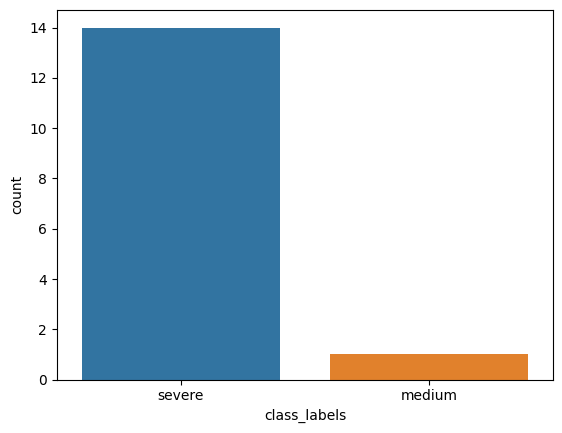

In [13]:
print(df_tsne["class_labels"].value_counts())
sns.countplot(x="class_labels",data=df_tsne[df_tsne['user_labels'] == '1000'])
print(df_tsne[df_tsne['user_labels'] == '1000']["class_labels"].value_counts())
#sns.countplot(x="class_labels",data=df_tsne)

<AxesSubplot:xlabel='X', ylabel='Y'>

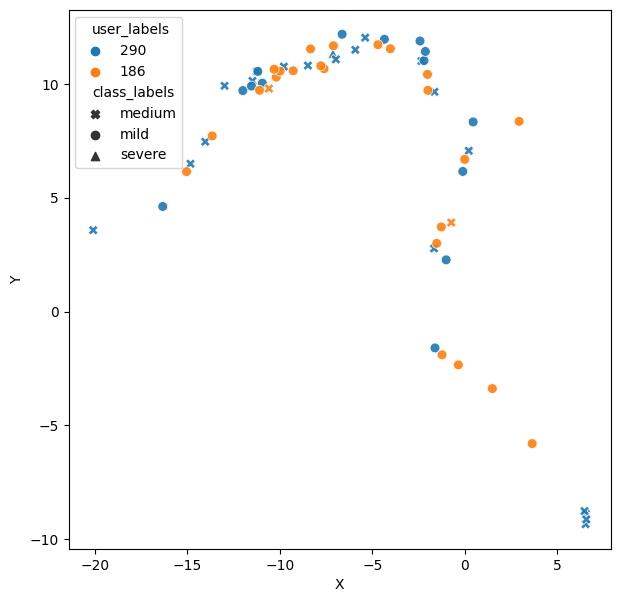

In [14]:
plt.figure(figsize=(7,7))

sns.scatterplot(
    x="X", y="Y",
    hue="user_labels",
    style="class_labels",
    data=replacement_df_tsne.loc[(replacement_df_tsne['user_labels'] == str(left_user)) | (replacement_df_tsne['user_labels'] == str(similar_user))],
    legend="full", s=50,
    alpha=0.9,
    markers=markers_dict
)

Baseline:
0.3235294117647059
Recall: 0.3235294117647059
Precision: 0.3235294117647059


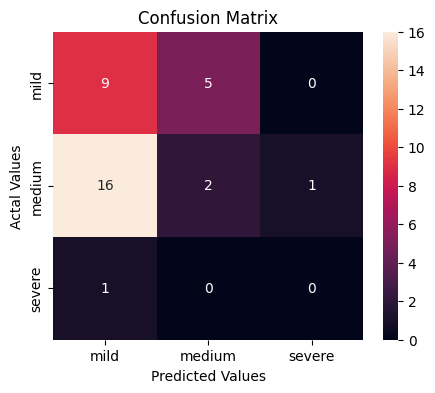

GNN:
0.38235294117647056
Recall: 0.38235294117647056
Precision: 0.38235294117647056


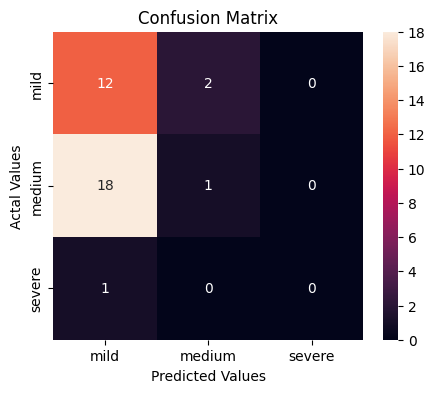

In [15]:
def analysis_result(x, true, clf):
    pred = clf.predict(x)
    recall = recall_score(y_true=true, y_pred=pred, average='micro')
    #roc_auc = roc_auc_score(y_true=gnn_y_test, y_score=gnn_y_pred, average='micro', multi_class='ovr')
    precision = precision_score(y_true=true, y_pred=pred, average='micro')
    print(f"Recall: {recall}")
    #print(f"ROC AUC: {roc_auc}")
    print(f"Precision: {precision}")
    cm = confusion_matrix(y_true=true, y_pred=pred)
    if cm.shape[0] == 2:
        cm_df = pd.DataFrame(cm,
                        index = ['mild','medium'], 
                        columns = ['mild','medium'])
    else:
        cm_df = pd.DataFrame(cm,
                            index = ['mild','medium','severe'], 
                            columns = ['mild','medium','severe'])

    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
def leave_one_out_validation(target_user, user_lst, gnn_embedding_lst, gnn_raw_lst, baseline_ds_lst):
    user_idx = user_lst.index(target_user)
    gnn_training_set = []
    baseline_training_set = []
    for i in range(len(gnn_embedding_lst)):
        if i == user_idx:
            continue
        else:
            gnn_training_set.extend(gnn_embedding_lst[i])
            baseline_training_set.extend(baseline_ds_lst[i])
    gnn_train_x = list(map(lambda x: x[0], gnn_training_set))
    gnn_train_y = list(map(lambda x: x[1], gnn_training_set))
    baseline_train_x = list(map(lambda x: x[0].ravel(), baseline_training_set))
    baseline_train_y = list(map(lambda x: x[1], baseline_training_set))

    most_similar_user = get_similarities(target_user, user_lst)[0][0]
    gnn_test = get_gnn_output(most_similar_user, gnn_raw_lst[user_idx])
    gnn_test_x = list(map(lambda x: x[0], gnn_test))
    gnn_test_y = list(map(lambda x: x[1], gnn_test))

    baseline_test_x = list(map(lambda x: x[0].ravel(), baseline_ds_lst[user_idx]))
    baseline_test_y = list(map(lambda x: x[1], baseline_ds_lst[user_idx]))
    print("Baseline:")
    base_clf = MLPClassifier(random_state=90, max_iter=300, hidden_layer_sizes=(50, 15,)).fit(baseline_train_x, baseline_train_y)
    print(base_clf.score(baseline_test_x, baseline_test_y))
    analysis_result(baseline_test_x, baseline_test_y, base_clf)
    print("GNN:")
    gnn_clf = MLPClassifier(random_state=90, max_iter=300, hidden_layer_sizes=(40,8,)).fit(gnn_train_x, gnn_train_y)
    print(gnn_clf.score(gnn_test_x, gnn_test_y))
    analysis_result(gnn_test_x, gnn_test_y, gnn_clf)

leave_one_out_validation(290, user_lst, gnn_ds_lst, gnn_raw_copy, baseline_ds_lst)

Baseline:
0.6666666666666666
Recall: 0.6666666666666666
Precision: 0.6666666666666666


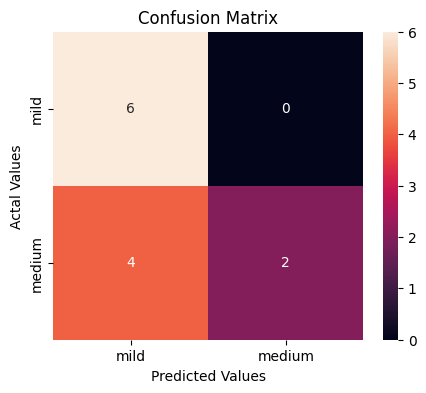

GNN:
0.5
Recall: 0.5
Precision: 0.5


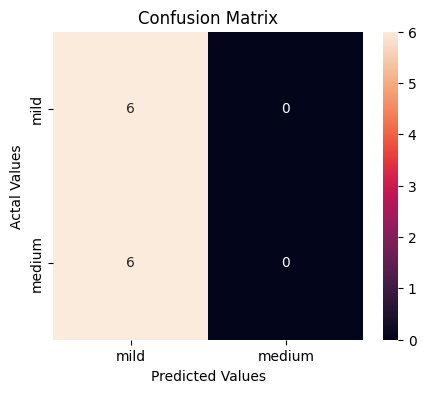

In [16]:
leave_one_out_validation(983, user_lst, gnn_ds_lst, gnn_raw_copy, baseline_ds_lst)

Baseline:
0.8333333333333334
Recall: 0.8333333333333334
Precision: 0.8333333333333334


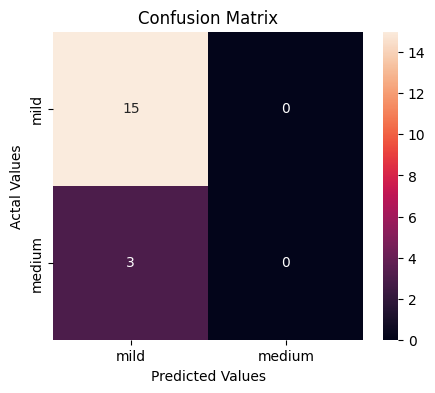

GNN:
0.5
Recall: 0.5
Precision: 0.5


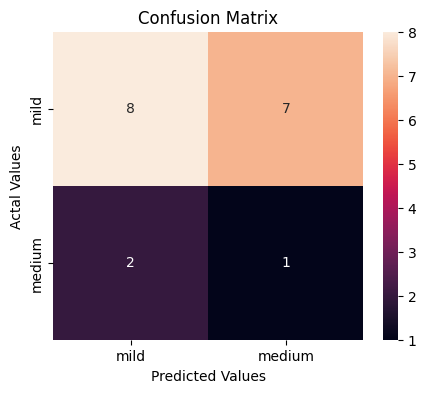

In [17]:
leave_one_out_validation(992, user_lst, gnn_ds_lst, gnn_raw_copy, baseline_ds_lst)

Baseline:
0.07142857142857142
Recall: 0.07142857142857142
Precision: 0.07142857142857142


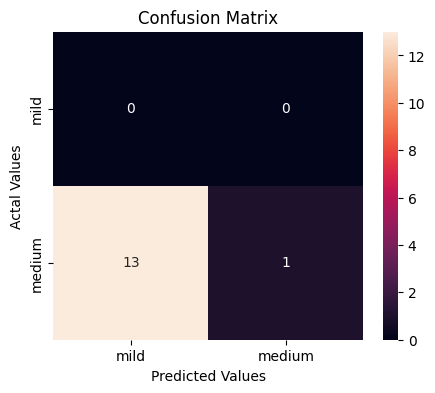

GNN:
0.42857142857142855
Recall: 0.42857142857142855
Precision: 0.42857142857142855


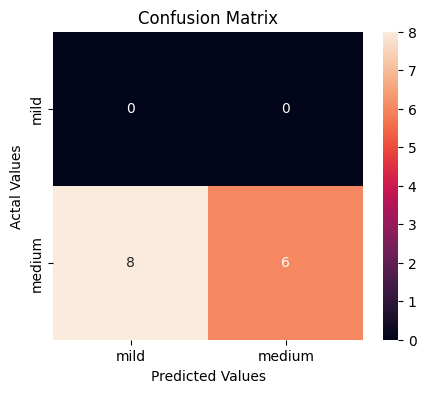

In [18]:
leave_one_out_validation(1717, user_lst, gnn_ds_lst, gnn_raw_copy, baseline_ds_lst)

Baseline:
0.2777777777777778
Recall: 0.2777777777777778
Precision: 0.2777777777777778


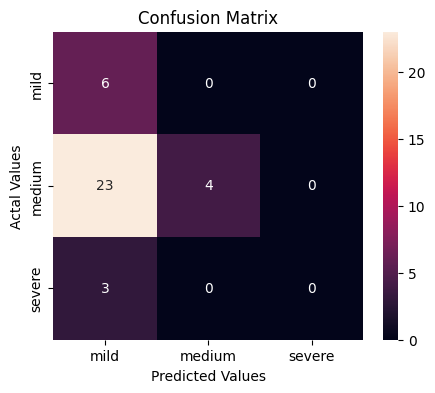

GNN:
0.19444444444444445
Recall: 0.19444444444444445
Precision: 0.19444444444444445


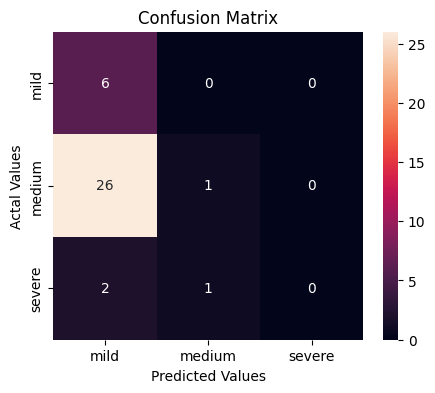

In [19]:
leave_one_out_validation(1032, user_lst, gnn_ds_lst, gnn_raw_copy, baseline_ds_lst)

Baseline:
0.5625
Recall: 0.5625
Precision: 0.5625


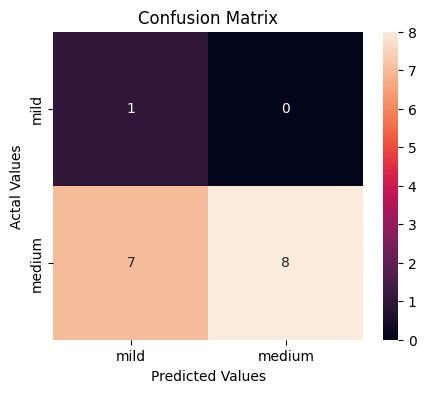

GNN:
0.0625
Recall: 0.0625
Precision: 0.0625


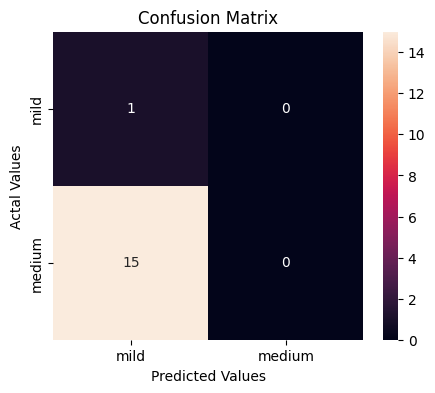

In [20]:
leave_one_out_validation(1436, user_lst, gnn_ds_lst, gnn_raw_copy, baseline_ds_lst)

Baseline:
0.3235294117647059
Recall: 0.3235294117647059
Precision: 0.3235294117647059


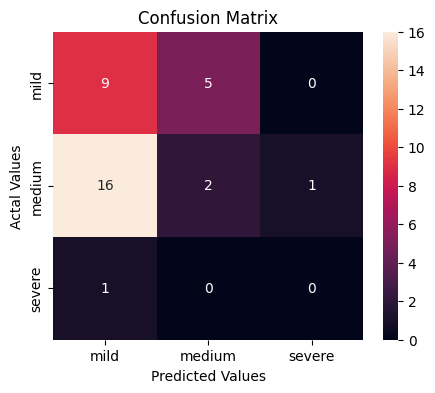

GNN:
0.38235294117647056
Recall: 0.38235294117647056
Precision: 0.38235294117647056


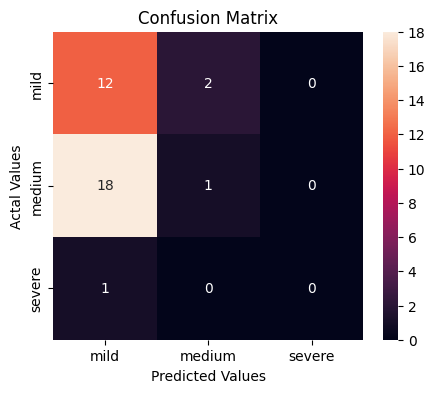

In [21]:
leave_one_out_validation(290, user_lst, gnn_ds_lst, gnn_raw_copy, baseline_ds_lst)

Baseline:
0.5
Recall: 0.5
Precision: 0.5


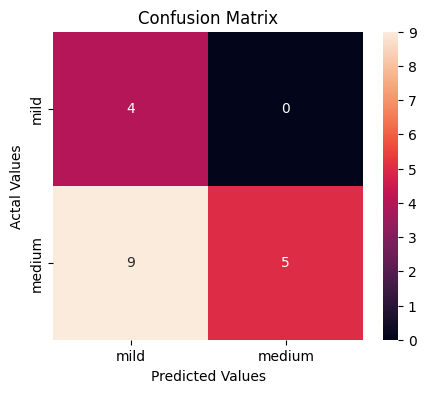

GNN:
0.2222222222222222
Recall: 0.2222222222222222
Precision: 0.2222222222222222


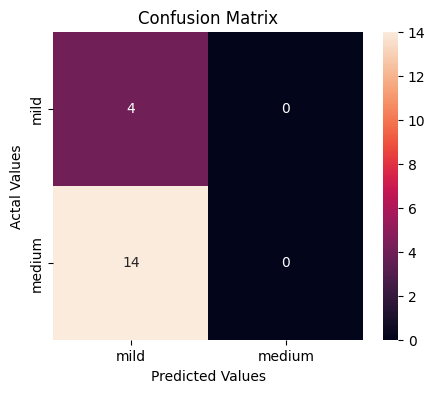

In [22]:
leave_one_out_validation(1386, user_lst, gnn_ds_lst, gnn_raw_copy, baseline_ds_lst)

In [23]:
# for u in user_lst:
#     print('='*20, u, '='*20)
#     leave_one_out_validation(u, user_lst, gnn_ds_lst, gnn_raw_copy, baseline_ds_lst)